Re-program the implicit differentiation optimization to check whether the program is corrected

In [ ]:
import torch
from torch.autograd import grad, Variable

In [ ]:
def gather_flat_grad(loss_grad):
    #Helper function to flatten the grad
    return torch.cat([p.view(-1) for p in loss_grad])  #g_vector

In [ ]:
# Set the seed for reproducibility
torch.manual_seed(1)

Observations:
- Even I set the the weight to be very close to w, the loss still fuctuates.
    - Thought: Maybe the update is too stochastic? Learning rate too high? or rand in x? Too small dataset?, no bias term?
    - Answer: rand in x, Fix by randn in x, increases number of epochs
- Predicted loss < True loss means do we find a better line than the one we are generated?
    - Happens when x is generated with rand (uniform generation) and when regularization

Conclusions:
- The SGD solution is approximately equal to the closed-form solution

In [ ]:
# THIS BLOCK SERVES AS AN EXACT SOLUTION
w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x_train.T, x_train)), x_train.T), y_train)
print('w_hat: ', w_hat)
y_train_predicted = torch.matmul(x_train, w_hat)
print('y_predicted: ', y_train_predicted)
loss = torch.nn.functional.mse_loss(y_train_predicted, y_train)
print('loss: ', loss)
true_loss = torch.nn.functional.mse_loss(torch.matmul(x_train, true_w), y_train)
print('true_loss: ', true_loss)

In [ ]:
# THIS BLOCK SERVES AS THE SANITY CHECK FOR THE MAIN TRAINING PROCESS
torch.manual_seed(1)
h_epoch = 10000  # Hyperparameter epoch
epoch = 1000  # Epoch for training

#Create underlying linear function
x = torch.randn((10, 2))
true_w = torch.tensor([[3.], [1.]])
y = torch.matmul(x, true_w) + torch.randn((10, 1))

# Split train_valid
x_train = x[:8, ]
y_train = y[:8, ]

x_valid = x[8:, ]
y_valid = y[8:, ]
#Parameters and hyperparameters
w = torch.tensor([[2.5], [1.3]], requires_grad=True)
lamb = torch.tensor([3.], requires_grad=True)  #Intentionally high value

#Define optimizer (Note: The choice of optimizer is similar to the problem setting)
optimizer = torch.optim.Adam([w], lr = 0.001)
h_optimizer = torch.optim.RMSprop([lamb])
for ep in range(epoch):
    total_train_loss = 0
    for i in range(len(x_train)):
        optimizer.zero_grad()
        y_predicted = torch.matmul(x_train[i], w)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i])
        total_train_loss += train_loss
        train_loss.backward()
        optimizer.step()
    print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))
    print('w: ', w)

This Section is using L2 regularization
Observations:
- The higher the lamb value, the higher the training loss and the more difference between closed-form weight solution and SGD weight solution.

In [ ]:
w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x_train.T, x_train) + lamb * torch.eye(2)), x_train.T), y_train)
print('w_hat: ', w_hat)
y_train_predicted = torch.matmul(x_train, w_hat)
print('y_predicted: ', y_train_predicted)
loss = torch.nn.functional.mse_loss(y_train_predicted, y_train)
print('loss: ', loss)
true_loss = torch.nn.functional.mse_loss(torch.matmul(x_train, true_w), y_train)
print('true_loss: ', true_loss)

In [ ]:
# THIS BLOCK SERVES AS THE SANITY CHECK FOR THE MAIN TRAINING PROCESS
torch.manual_seed(1)
h_epoch = 10000  # Hyperparameter epoch
epoch = 1000  # Epoch for training

#Create underlying linear function
x = torch.randn((10, 2))
true_w = torch.tensor([[3.], [1.]])
y = torch.matmul(x, true_w) + torch.randn((10, 1))

# Split train_valid
x_train = x[:8, ]
y_train = y[:8, ]

x_valid = x[8:, ]
y_valid = y[8:, ]
#Parameters and hyperparameters
w = torch.tensor([[2.5], [1.3]], requires_grad=True)
lamb = torch.tensor([0.01], requires_grad=True)  #Change the value form 3 to 0.1 and 0.01 and observe the behavior

#Define optimizer (Note: The choice of optimizer is similar to the problem setting)
optimizer = torch.optim.Adam([w], lr = 0.001)
h_optimizer = torch.optim.RMSprop([lamb])
for ep in range(epoch):
    total_train_loss = 0
    for i in range(len(x_train)):
        optimizer.zero_grad()
        y_predicted = torch.matmul(x_train[i], w)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb  * torch.sum(w ** 2)
        total_train_loss += train_loss
        train_loss.backward()
        optimizer.step()
    print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))
    print('w: ', w)

The following block combines the optimization of weight and hyperparameter together
Observations:
    - The training loss still decreases even when the hyperparameter is wrong, but after hyperparameter adjusts, the training loss seems to decrease compared to previous hepoch, but not during epoch.
        - Question: Does this mean the loss already converge? Does this mean optimizing lambda is not important?
        - Thought: Which hyperparameter should we optimize?
    - After epoch 200, the hyperparameter becomes negative, but stop at -0.0927. Used the optimal weight, the loss is even higher compared with the lambda = 0.01
        - Question: Overfitting?
    - Training epoch vs Hyperparam epoch
    - Note: We have individual lambda for each weight in implicit optimization code
    - Note: Train loss and validation loss in implicit opt code always decrease, train acc and validation acc also increases, but the test loss INCREASES, and the test acc DOES NOT improve


In [ ]:
torch.manual_seed(1)
h_epoch = 10000  # Hyperparameter epoch
epoch = 1000  # Epoch for training

#Create underlying linear function
x = torch.randn((10, 2)).cuda()
true_w = torch.tensor([[3.], [1.]]).cuda()
y = torch.matmul(x, true_w) + torch.randn((10, 1))

# Split train_valid
x_train = x[:8, ]
y_train = y[:8, ].cuda()

x_valid = x[8:, ]
y_valid = y[8:, ].cuda()
#Parameters and hyperparameters
w = torch.tensor([[2.5], [1.3]], requires_grad=True).cuda()
lamb = torch.tensor([3.], requires_grad=True).cuda()  #Intentionally high value

#Define optimizer (Note: The choice of optimizer is similar to the problem setting)
optimizer = torch.optim.Adam([w], lr = 0.001)
h_optimizer = torch.optim.RMSprop([lamb])

# Note the update is currently very noisy
# Define the loop
for hep in range(h_epoch):
    # Train (SGD)
    for ep in range(epoch):
        total_train_loss = 0
        for i in range(len(x_train)):
            optimizer.zero_grad()
            y_predicted = torch.matmul(x_train[i], w)
            train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb * torch.sum(w ** 2)
            total_train_loss += train_loss
            train_loss.backward(create_graph=True)
            optimizer.step()
        # if ep % 100 == 0: # Only print every 100 epoch
        #     print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))

    # Train the hyperparameter
    total_d_val_loss_d_lamb = torch.zeros(lamb.size())
    d_valid_loss_d_w = torch.zeros(w.size())
    for i in range(len(x_valid)):
        w.grad.zero_()
        y_predicted = torch.matmul(x_valid[i], w)
        valid_loss = torch.nn.functional.mse_loss(y_predicted, y_valid[i])
        valid_loss_grad = grad(valid_loss, w)
        d_valid_loss_d_w += valid_loss_grad[0]
    d_valid_loss_d_w /= len(x_valid)

    for i in range(len(x_train)):
        y_predicted = torch.matmul(x_train[i], w)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i]) + lamb * torch.sum(w ** 2)
        w.grad.zero_(), h_optimizer.zero_grad()
        d_train_loss_d_w = grad(train_loss, w, create_graph=True)

        w.grad.zero_(), h_optimizer.zero_grad()
        d_train_loss_d_w[0].backward(d_valid_loss_d_w)

        if lamb.grad is not None:
            total_d_val_loss_d_lamb -= lamb.grad
    total_d_val_loss_d_lamb /= len(x_train)

    lamb.grad = total_d_val_loss_d_lamb
    h_optimizer.step()

    w.grad.zero_(), h_optimizer.zero_grad()
    print('lamb after epoch '+ str(hep) + ': ' + str(lamb))
    print('w value: ', w)



Test the output with optimal weight

In [ ]:
best_lambda = -0.0927
w_hat = torch.tensor([[4.0337], [1.2063]])
# w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x_train.T, x_train) + lamb * torch.eye(2)), x_train.T), y_train)
print('w_hat: ', w_hat)
y_train_predicted = torch.matmul(x_train, w_hat)
print('y_predicted: ', y_train_predicted)
loss = torch.nn.functional.mse_loss(y_train_predicted, y_train)
print('loss: ', loss)
true_loss = torch.nn.functional.mse_loss(torch.matmul(x_train, true_w), y_train)
print('true_loss: ', true_loss)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable

Redesign the experiment: Creating an overfitting situation

In [2]:
torch.manual_seed(1)

# Generate the dataset
x = torch.randn((30,1))
size_x = x.size()
poly_x = torch.cat((x, x**2, x**3, x**4, x**5), 1)

# Add one column to learn intercept terms
x_ones = torch.cat((torch.ones(size_x), x),1)
poly_x_ones = torch.cat((torch.ones(size_x),poly_x), 1)

true_w = torch.tensor([[1.], [2.]])
y = torch.matmul(x_ones, true_w) + torch.randn(size_x)
true_y = torch.matmul(x_ones, true_w)

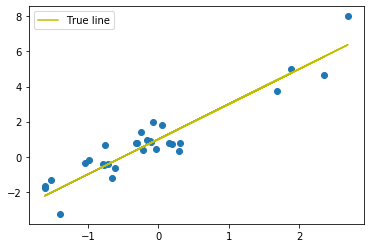

In [3]:
plt.clf()
plt.scatter(x, y)
plt.plot(x, true_y, color='y', label='True line')
plt.legend(loc='best')

In [4]:
# Separate the train and the valid
x_train = x_ones[:25,]
y_train = y[:25,]

x_valid = x_ones[25:,]
y_valid = y[25:,]

poly_x_train = poly_x_ones[:25,]
poly_x_valid = poly_x_ones[25:,]

In [5]:
#Parameters and hyperparameters
w = torch.tensor([[2.5], [1.3]], requires_grad=True)
poly_w = torch.tensor([[2.5], [1.3], [2.], [1.], [-1.], [-0.5]], requires_grad=True)
lamb = torch.tensor([3.], requires_grad=True)  #Intentionally high value

#Define optimizer (Note: The choice of optimizer is similar to the problem setting)
optimizer = torch.optim.Adam([w], lr = 0.001)
poly_optimizer = torch.optim.Adam([poly_w], lr=0.001)
h_optimizer = torch.optim.RMSprop([lamb])

Calculate w_hat using closed-form solution (linear function)

In [6]:
w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x_train.T, x_train)), x_train.T), y_train)
print('w_hat: ', w_hat)
y_train_predicted = torch.matmul(x_train, w_hat)
loss = torch.nn.functional.mse_loss(y_train_predicted, y_train)
print('train loss: ', loss)
y_valid_predicted = torch.matmul(x_valid, w_hat)
loss = torch.nn.functional.mse_loss(y_valid_predicted, y_valid)
print('val loss: ', loss)

w_hat:  tensor([[1.1714],
        [2.0775]])
train loss:  tensor(0.5160)
val loss:  tensor(0.9862)


Calculate poly_w_hat using closed-form solution (5-th order function)

In [7]:
poly_w_hat = torch.matmul(torch.matmul(torch.inverse(torch.matmul(poly_x_train.T, poly_x_train)), poly_x_train.T), y_train)
print('poly_w_hat: ', poly_w_hat)
poly_y_train_predicted = torch.matmul(poly_x_train, poly_w_hat)
poly_train_loss = torch.nn.functional.mse_loss(poly_y_train_predicted, y_train)
print('poly train loss: ', poly_train_loss)
poly_y_valid_predicted = torch.matmul(poly_x_valid, poly_w_hat)
poly_val_loss = torch.nn.functional.mse_loss(poly_y_valid_predicted, y_valid)
print('poly val loss: ', poly_val_loss)

poly_w_hat:  tensor([[ 1.0745],
        [ 0.1122],
        [-1.9558],
        [ 1.3245],
        [ 0.7126],
        [-0.3005]])
poly train loss:  tensor(0.3196)
poly val loss:  tensor(2.5492)


Note:
- Train loss is smaller, but validation loss for polynomial regression is greater than linear regression.
- The weights for first order are similar to true weights, whereas the weights for 5-th order are very off.
Conclusion:
- Overfitting!! (The plot below shows this issue)

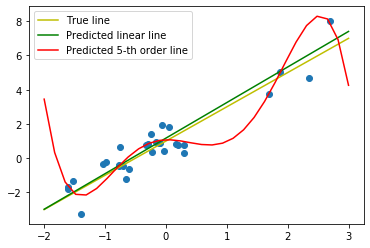

In [8]:
# x, y here simply for visualization
x_plot = torch.linspace(-2, 3, steps = 30)
x_plot = x_plot.resize_((x_plot.size(0), 1))
plot_size = x_plot.size()
x_plot_ones = torch.cat((torch.ones(plot_size), x_plot), 1)
poly_x_plot_ones = torch.cat((torch.ones(plot_size), x_plot, x_plot**2, x_plot**3,x_plot**4,x_plot**5),1)
y_plot = torch.matmul(x_plot_ones, true_w)

plt.clf()
plt.scatter(x, y)
plt.plot(x_plot, y_plot, color='y', label='True line')
plt.plot(x_plot, torch.matmul(x_plot_ones, w_hat), color='g', label='Predicted linear line')
plt.plot(x_plot, torch.matmul(poly_x_plot_ones, poly_w_hat), color='r', label='Predicted 5-th order line')
plt.legend(loc='best')

Run with SGD to show how close the closed-form solution with SGD solution

SGD solution is [1.1712, 2.0772], which is very close to the closed-form solution. The training loss and validation loss are also similar

In [14]:
epoch = 5000
for ep in range(epoch):
    total_train_loss = 0
    for i in range(len(x_train)):
        optimizer.zero_grad()
        y_predicted = torch.matmul(x_train[i], w)
        train_loss = torch.nn.functional.mse_loss(y_predicted, y_train[i])
        total_train_loss += train_loss
        train_loss.backward()
        optimizer.step()
    print('Train loss at ' + str(ep) + ': ' + str(total_train_loss / len(x_train)))
    print('w at ' + str(ep) + ': ' +  str(w))
y_valid_predicted = torch.matmul(x_valid, w)
loss = torch.nn.functional.mse_loss(y_valid_predicted, y_valid)
print('val loss: ', loss)

Train loss at 0: tensor(0.5167, grad_fn=<DivBackward0>)
w at 0: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 1: tensor(0.5167, grad_fn=<DivBackward0>)
w at 1: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 2: tensor(0.5167, grad_fn=<DivBackward0>)
w at 2: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 3: tensor(0.5167, grad_fn=<DivBackward0>)
w at 3: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 4: tensor(0.5167, grad_fn=<DivBackward0>)
w at 4: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 5: tensor(0.5167, grad_fn=<DivBackward0>)
w at 5: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 6: tensor(0.5167, grad_fn=<DivBackward0>)
w at 6: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 7: tensor(0.5167, grad_fn=<DivBackward0>)
w at 7: tensor([[1.1712],
        [2.0772]], requires_grad=True)
Train loss at 8: tensor(0.5167, 

In [18]:
epoch = 5000
for ep in range(epoch):
    total_poly_train_loss = 0
    for i in range(len(poly_x_train)):
        poly_optimizer.zero_grad()
        poly_y_predicted = torch.matmul(poly_x_train[i], poly_w)
        poly_train_loss = torch.nn.functional.mse_loss(poly_y_predicted, y_train[i])
        total_poly_train_loss += poly_train_loss
        poly_train_loss.backward()
        poly_optimizer.step()
    print('poly train loss at ' + str(ep) + ': ' + str(total_poly_train_loss / len(poly_x_train)))
    print('poly w at ' + str(ep) + ': ' +  str(poly_w))
poly_y_valid_predicted = torch.matmul(poly_x_valid, poly_w)
loss = torch.nn.functional.mse_loss(poly_y_valid_predicted, y_valid)
print('val loss: ', loss)

poly train loss at 0: tensor(0.3284, grad_fn=<DivBackward0>)
poly w at 0: tensor([[ 1.0734],
        [ 0.2178],
        [-1.8425],
        [ 1.2434],
        [ 0.6722],
        [-0.2802]], requires_grad=True)
poly train loss at 1: tensor(0.3302, grad_fn=<DivBackward0>)
poly w at 1: tensor([[ 1.0731],
        [ 0.2168],
        [-1.8443],
        [ 1.2412],
        [ 0.6699],
        [-0.2827]], requires_grad=True)
poly train loss at 2: tensor(0.3284, grad_fn=<DivBackward0>)
poly w at 2: tensor([[ 1.0734],
        [ 0.2178],
        [-1.8426],
        [ 1.2435],
        [ 0.6723],
        [-0.2802]], requires_grad=True)
poly train loss at 3: tensor(0.3302, grad_fn=<DivBackward0>)
poly w at 3: tensor([[ 1.0731],
        [ 0.2167],
        [-1.8443],
        [ 1.2413],
        [ 0.6699],
        [-0.2827]], requires_grad=True)
poly train loss at 4: tensor(0.3284, grad_fn=<DivBackward0>)
poly w at 4: tensor([[ 1.0734],
        [ 0.2177],
        [-1.8426],
        [ 1.2435],
        [ 0.67